#  Setup

In [164]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from operator import itemgetter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pybaseball.cache.enable()
data = statcast('2022-04-07', '2022-10-05')

print(data.shape)
data.head(10)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.8/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 182/182 [13:44<00:00,  4.53s/it]


(708540, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3171,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3387,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3467,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3590,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3846,FC,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031
3886,FF,2022-10-05,97.5,-0.56,6.68,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,194,0.0,0.023
4028,CH,2022-10-05,84.9,-0.58,6.65,"Baker, Bryan",665489,641329,strikeout,called_strike,...,5,4,5,4,5,Standard,Standard,207,0.071,-0.158
4181,FF,2022-10-05,98.2,-0.59,6.72,"Baker, Bryan",665489,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,190,0.0,0.017
4387,CH,2022-10-05,83.8,-0.41,6.57,"Baker, Bryan",665489,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,211,0.0,-0.046
4557,FF,2022-10-05,96.7,-0.41,6.75,"Baker, Bryan",665489,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.034


In [7]:
"""data = pd.read_csv('data2022.csv')
data.shape"""

(56167, 93)

# Data Cleaning

## Determining Training Data Columns

In [8]:
for i in zip(data.columns, data.dtypes):
  print(i)

('Unnamed: 0', dtype('int64'))
('pitch_type', dtype('O'))
('game_date', dtype('O'))
('release_speed', dtype('float64'))
('release_pos_x', dtype('float64'))
('release_pos_z', dtype('float64'))
('player_name', dtype('O'))
('batter', dtype('int64'))
('pitcher', dtype('int64'))
('events', dtype('O'))
('description', dtype('O'))
('spin_dir', dtype('float64'))
('spin_rate_deprecated', dtype('float64'))
('break_angle_deprecated', dtype('float64'))
('break_length_deprecated', dtype('float64'))
('zone', dtype('int64'))
('des', dtype('O'))
('game_type', dtype('O'))
('stand', dtype('O'))
('p_throws', dtype('O'))
('home_team', dtype('O'))
('away_team', dtype('O'))
('type', dtype('O'))
('hit_location', dtype('float64'))
('bb_type', dtype('O'))
('balls', dtype('int64'))
('strikes', dtype('int64'))
('game_year', dtype('int64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))
('on_3b', dtype('float64'))
('on_2b', dtype('float64'))
('o

https://baseballsavant.mlb.com/csv-docs 

Which columns should we keep based on the documentation? Any metrics derived from the movement of the pitch alone, with no regard for the pitcher who threw it except for the handedness of the pitcher.
  - Motivation: different pitch mixes for different hands of pitchers (e.g. more right-handed changeups than left-handed)

In [9]:
data = data[['pitcher', 'player_name', 'pitch_type', "p_throws",'pitch_name', 'release_spin_rate', 'release_speed','effective_speed', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [10]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', dtype('int64'))
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', dtype('float64'))
('release_speed', dtype('float64'))
('effective_speed', dtype('float64'))
('spin_axis', dtype('float64'))
('vx0', dtype('float64'))
('vy0', dtype('float64'))
('vz0', dtype('float64'))
('ax', dtype('float64'))
('ay', dtype('float64'))
('az', dtype('float64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))


In [11]:
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    18085
Slider             11661
Sinker              9124
Changeup            6241
Curveball           5003
Cutter              4171
Knuckle Curve       1142
Split-Finger         624
Fastball              72
Eephus                43
Name: pitch_name, dtype: int64

In [12]:
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    18085
SL    11661
SI     9124
CH     6241
CU     5001
FC     4172
KC     1142
FS      624
FA       72
EP       43
CS        2
Name: pitch_type, dtype: int64

In [13]:
data[data['pitch_name'] == 'Fastball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
6761,620443,"Torrens, Luis",FA,R,Fastball,2028.0,88.8,87.4,198.0,5.908894,-129.211593,-6.160026,-9.017058,23.988244,-16.007847,-0.70,1.34,0.83,2.94
6762,620443,"Torrens, Luis",FA,R,Fastball,2013.0,87.1,86.0,210.0,7.767040,-126.695007,-5.562338,-13.780615,23.249160,-19.449337,-1.14,1.09,0.36,2.11
6763,620443,"Torrens, Luis",FA,R,Fastball,2006.0,84.8,83.5,215.0,5.576926,-123.404175,-4.159193,-5.468194,23.603541,-16.933643,-0.43,1.43,0.36,2.97
6764,620443,"Torrens, Luis",FA,R,Fastball,1920.0,85.1,84.2,205.0,8.035447,-123.709060,-4.118744,-8.744140,22.830860,-21.535999,-0.70,0.97,1.11,2.37
6765,620443,"Torrens, Luis",FA,R,Fastball,1929.0,86.6,85.1,197.0,10.013253,-125.686932,-5.303777,-13.215244,24.124622,-19.228439,-1.06,1.13,1.72,2.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49676,593643,"Alberto, Hanser",FA,R,Fastball,1220.0,59.8,58.3,216.0,1.412501,-87.112057,1.145620,-0.313646,11.429277,-27.028098,-0.03,1.07,-0.69,2.30
49677,593643,"Alberto, Hanser",FA,R,Fastball,1397.0,63.8,62.4,221.0,6.841870,-92.788142,-2.960255,-3.299564,12.212847,-25.073851,-0.41,1.18,2.04,0.63
49678,593643,"Alberto, Hanser",FA,R,Fastball,1407.0,62.5,60.6,231.0,0.472315,-91.022468,1.124101,-3.920425,12.363618,-26.066002,-0.69,1.16,-2.05,2.72
51485,606115,"Arcia, Orlando",FA,R,Fastball,1961.0,84.1,82.9,216.0,4.737246,-122.409557,-5.156817,-7.215210,23.748070,-17.525037,-0.63,1.37,0.05,2.19


In [14]:
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Alberto, Hanser     35
Torrens, Luis       15
Dickerson, Corey    12
Maton, Nick          3
Vargas, Ildemaro     2
Lopez, Alejo         2
Arcia, Orlando       2
Clemens, Kody        1
Name: player_name, dtype: int64

In [15]:
data[data['pitch_name'] == 'Eephus']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
22034,545121,"Vargas, Ildemaro",EP,R,Eephus,841.0,38.6,37.1,204.0,0.657855,-54.456680,11.293683,0.051253,5.996353,-30.418288,0.06,1.67,-0.16,4.32
22036,545121,"Vargas, Ildemaro",EP,R,Eephus,812.0,38.9,37.2,216.0,-0.237409,-54.731675,12.313730,-0.238409,5.931549,-30.790850,-0.13,1.51,-0.99,5.20
22038,545121,"Vargas, Ildemaro",EP,R,Eephus,898.0,39.0,37.6,214.0,1.599343,-55.654232,9.203681,-0.112455,6.065402,-29.648962,0.03,1.86,0.50,2.68
22039,545121,"Vargas, Ildemaro",EP,R,Eephus,786.0,38.8,37.7,200.0,-0.054562,-55.025723,10.620663,0.609237,4.665442,-30.573263,0.30,1.33,-0.71,3.81
23315,665019,"Clemens, Kody",EP,R,Eephus,1042.0,46.1,44.3,201.0,0.513493,-66.848762,5.700501,-0.052311,5.908564,-28.959118,0.00,1.28,-0.85,3.74
23316,665019,"Clemens, Kody",EP,R,Eephus,1218.0,59.9,58.3,201.0,0.647720,-87.370846,-0.226810,1.707023,11.299112,-23.731711,0.35,1.67,-1.03,2.67
23318,665019,"Clemens, Kody",EP,R,Eephus,1259.0,59.4,57.4,198.0,1.318041,-86.473664,0.163884,5.096068,13.208701,-24.609771,1.06,1.57,0.19,2.69
23319,665019,"Clemens, Kody",EP,R,Eephus,1322.0,63.3,61.6,205.0,-1.814574,-92.219778,0.044322,1.594258,12.705120,-24.206130,0.23,1.42,-2.79,3.15
23320,665019,"Clemens, Kody",EP,R,Eephus,1154.0,57.6,55.7,203.0,0.629410,-83.847856,0.714463,-0.192832,10.946945,-24.482142,-0.02,1.69,-1.22,2.97
23321,665019,"Clemens, Kody",EP,R,Eephus,1150.0,58.0,55.9,201.0,1.637669,-84.365289,0.394140,3.304114,12.394535,-23.892935,0.75,1.81,0.38,2.84


In [16]:
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Clemens, Kody       13
Lopez, Alejo        12
Arcia, Orlando       8
Dickerson, Corey     6
Vargas, Ildemaro     4
Name: player_name, dtype: int64

In [17]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z


In [18]:
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Series([], Name: player_name, dtype: int64)

In [19]:
# number of rows to delete
pitch_names[-3:].sum()

739

In [20]:
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]
df.shape

(56052, 19)

In [21]:
print(data.shape[0] - df.shape[0])

115


In [22]:
df

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",CH,R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",CH,R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",FC,R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56162,592791,"Taillon, Jameson",FC,R,Cutter,2487.0,88.9,89.2,189.0,4.120077,-129.293132,-5.742961,2.339776,26.856683,-17.589725,0.28,1.21,0.45,2.27
56163,592791,"Taillon, Jameson",FF,R,4-Seam Fastball,2366.0,93.9,94.5,211.0,7.108558,-136.329495,-9.194264,-8.404847,29.701533,-9.224029,-0.55,1.69,0.98,1.69
56164,608379,"Wacha, Michael",FC,R,Cutter,2088.0,86.0,87.5,189.0,5.011237,-125.264056,-4.112517,2.684455,21.237452,-23.822720,0.33,0.73,1.01,2.88
56165,608379,"Wacha, Michael",CH,R,Changeup,1565.0,83.2,84.0,236.0,1.755403,-121.179117,-5.790207,-9.374153,21.749129,-20.952532,-0.91,1.05,-1.31,2.32


## Missing Values

In [23]:
df.isnull().sum()

pitcher                0
player_name            0
pitch_type             0
p_throws               0
pitch_name             1
release_spin_rate    146
release_speed          3
effective_speed       10
spin_axis            143
vx0                    1
vy0                    1
vz0                    1
ax                     1
ay                     1
az                     1
pfx_x                  0
pfx_z                  1
plate_x                1
plate_z                1
dtype: int64

In [24]:
# Example: Find top 10 pitchers with most "missing" spin rate metrics 
df[df['release_spin_rate'].isna()].player_name.value_counts()[:10]

Hernández, Carlos       34
Civale, Aaron           21
Weaver, Luke            18
Morgan, Eli             14
De Los Santos, Enyel    13
Heasley, Jonathan        8
Miller, Tyson            8
Stephan, Trevor          8
Davidson, Tucker         4
King, John               3
Name: player_name, dtype: int64

Option A: Go through all missing metrics for each pitcher, take their averages for each column and fill in all missing values with average

Option B: Delete all rows that contain *any* missing values

In [25]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast',round(100 * (missing_row_vals / data.shape[0]), 2))

152
Percentage Error of Statcast 0.27


In [26]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(55900, 18)
Number of rows removed: 152


In [27]:
df

,pitcher,player_name,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55895,592791,"Taillon, Jameson",R,Sinker,2326.0,94.5,95.6,208.0,4.263729,-137.495991,-7.372076,-15.902961,28.472445,-13.307007,-1.18,1.37,-0.74,2.03
55896,592791,"Taillon, Jameson",R,Cutter,2487.0,88.9,89.2,189.0,4.120077,-129.293132,-5.742961,2.339776,26.856683,-17.589725,0.28,1.21,0.45,2.27
55897,592791,"Taillon, Jameson",R,4-Seam Fastball,2366.0,93.9,94.5,211.0,7.108558,-136.329495,-9.194264,-8.404847,29.701533,-9.224029,-0.55,1.69,0.98,1.69
55898,608379,"Wacha, Michael",R,Cutter,2088.0,86.0,87.5,189.0,5.011237,-125.264056,-4.112517,2.684455,21.237452,-23.822720,0.33,0.73,1.01,2.88


# Analysis

## Visualization

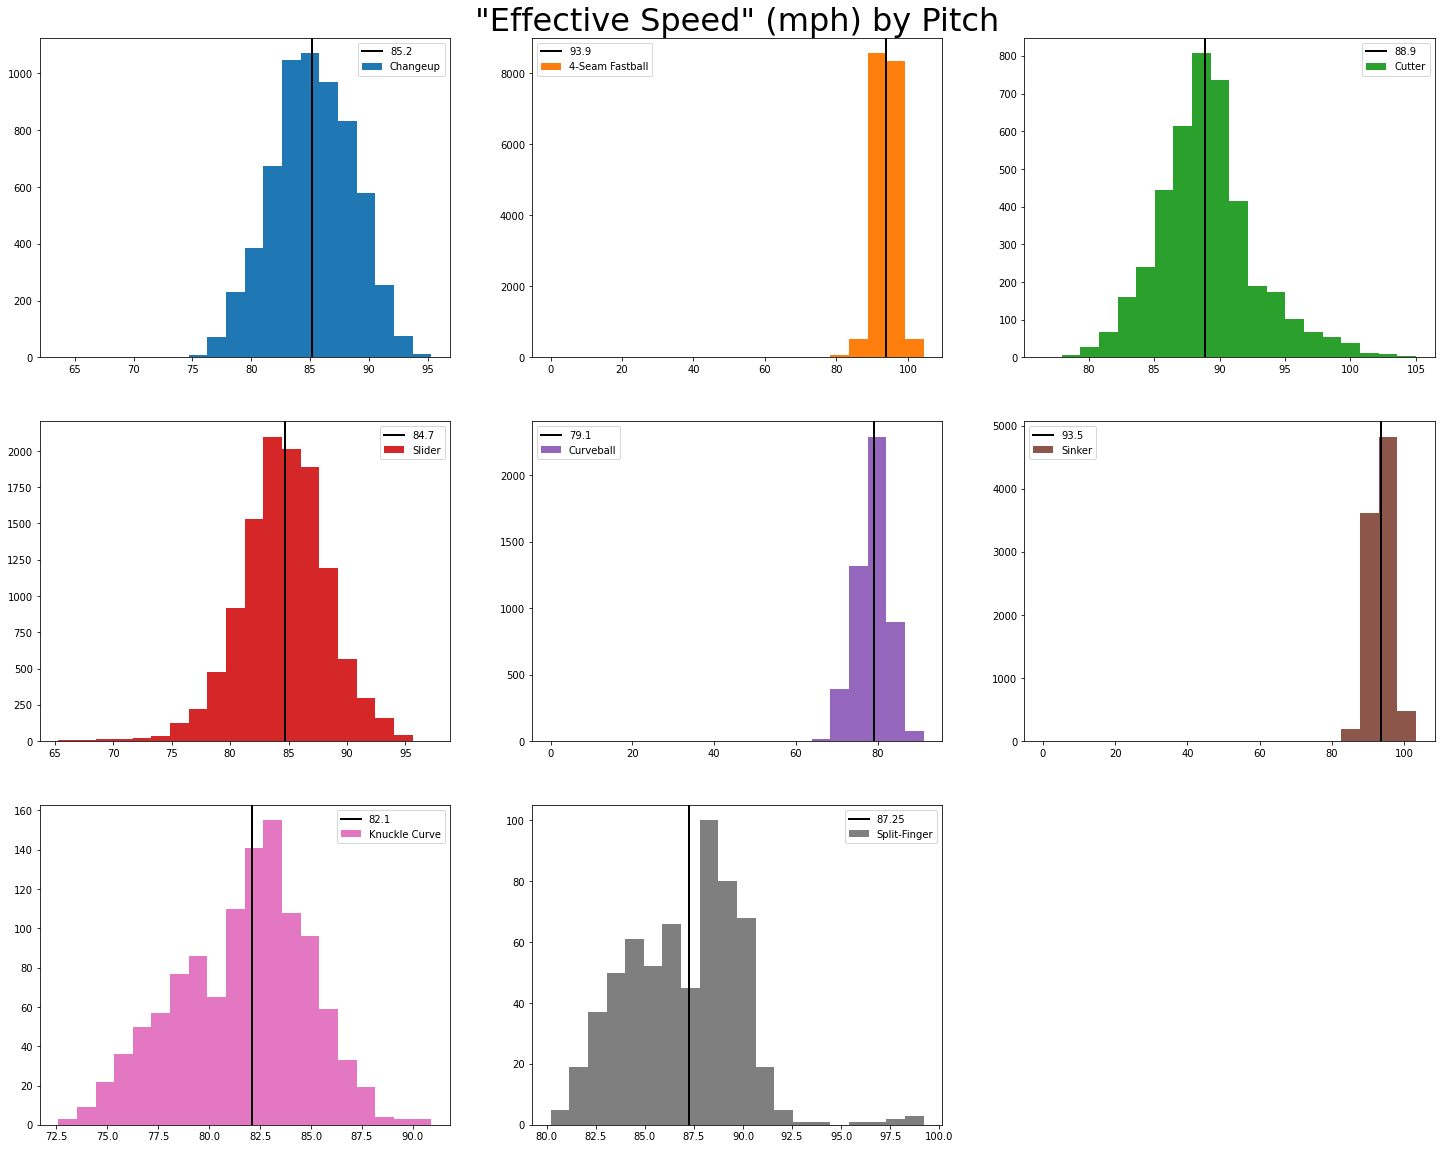

In [33]:
# Generate a pyplot figure
fig = plt.figure(figsize = (25,20))

# Set title
plt.title('"Effective Speed" (mph) by Pitch', fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each unique pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For effective speed (release speed & extension), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  # Iterate to next color in rotation
  c = next(colors)["color"]

  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.effective_speed[df.pitch_name==val]
  
  ax = fig.add_subplot(3, 3, i+1)
  ax.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax.legend()

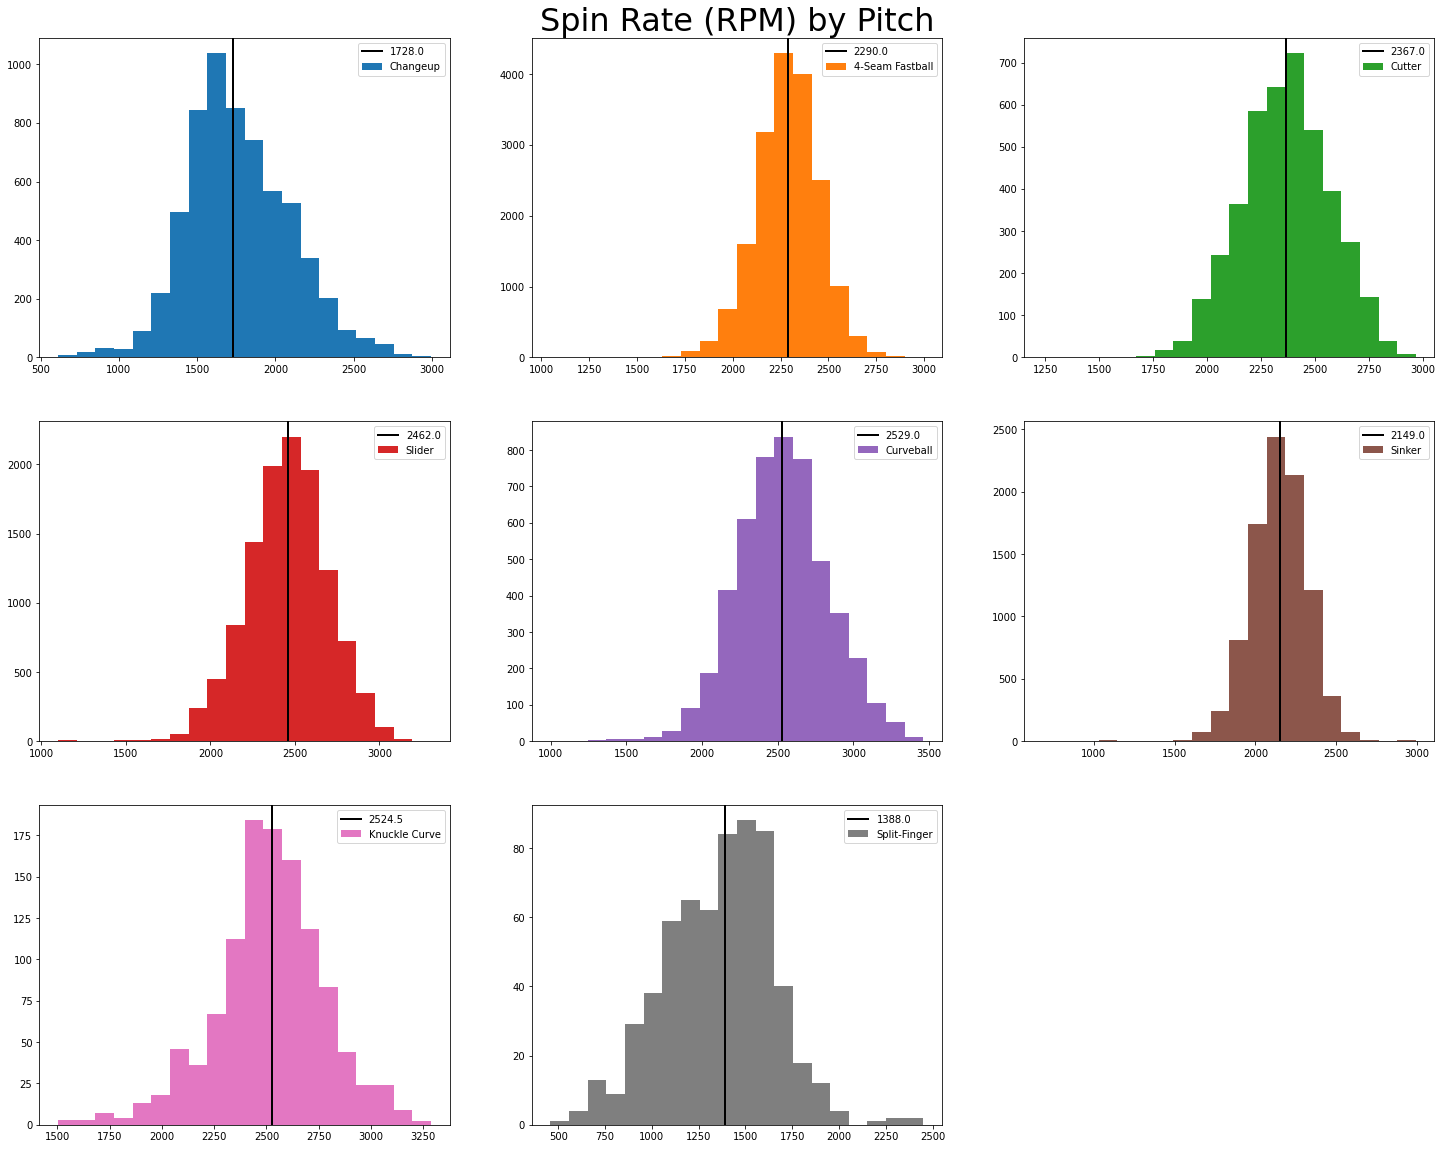

In [34]:
# Generate a pyplot figure
fig2 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Rate (RPM) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.release_spin_rate[df.pitch_name==val]
  ax2 = fig2.add_subplot(3, 3, i+1)
  ax2.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax2.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax2.legend()

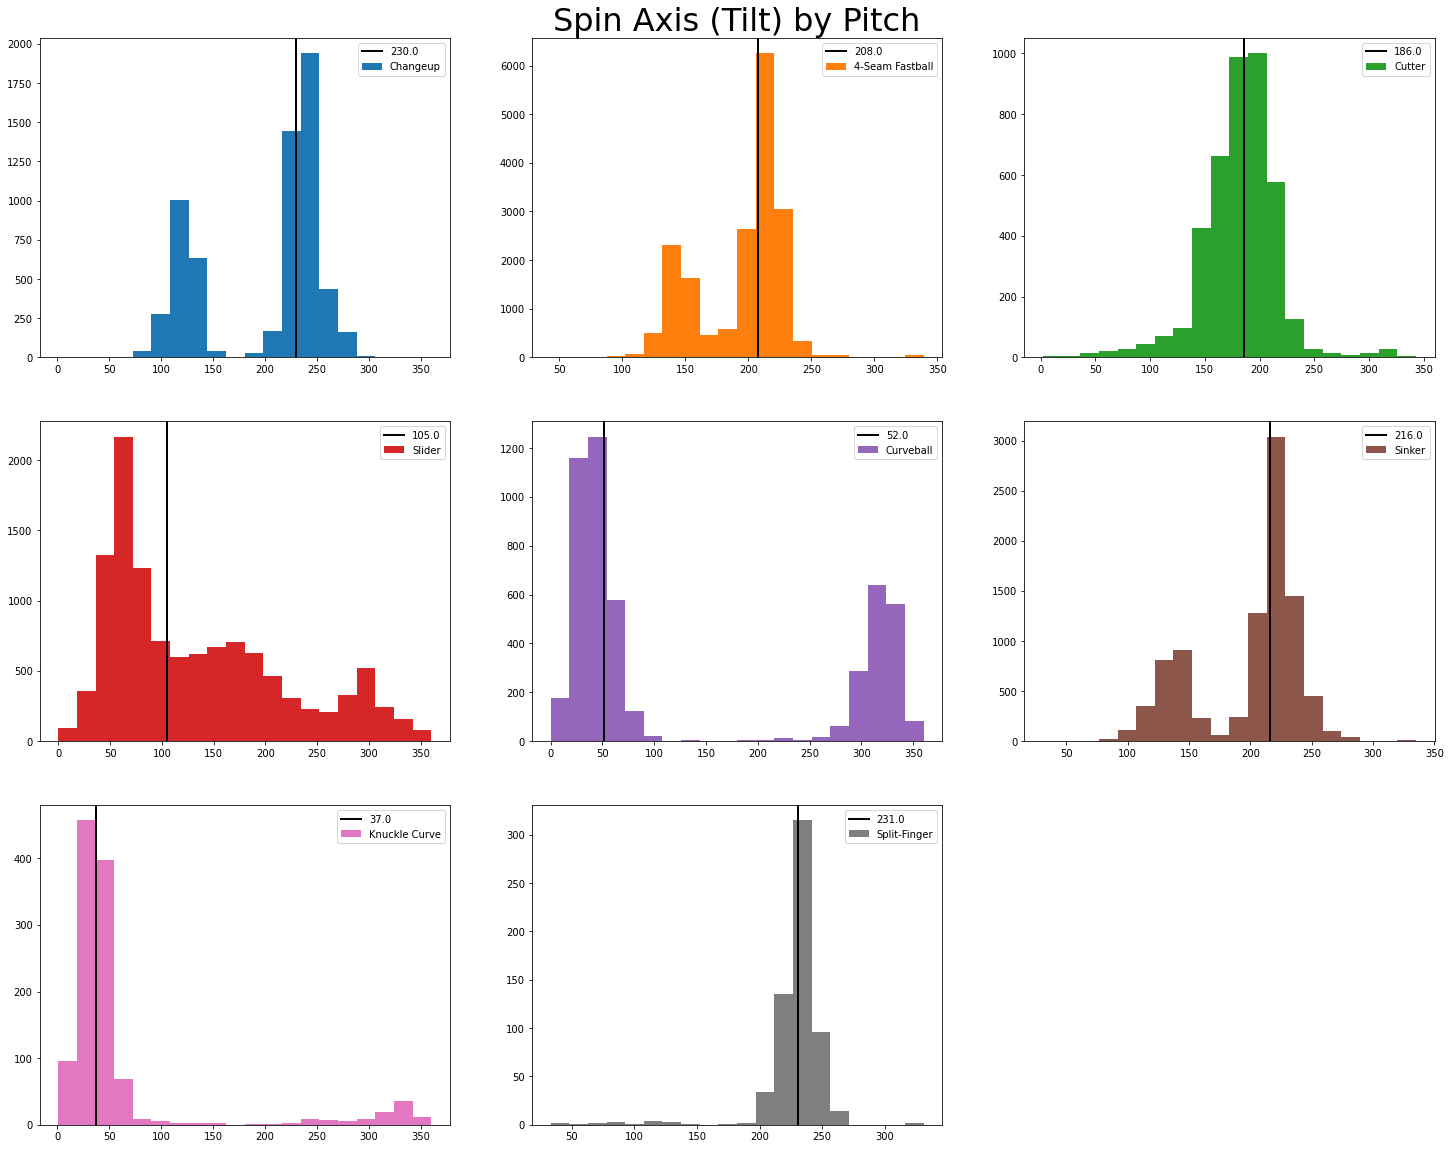

In [35]:
# Generate a pyplot figure
fig3 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Axis (Tilt) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.spin_axis[df.pitch_name==val]
  ax3 = fig3.add_subplot(3, 3, i+1)
  ax3.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax3.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax3.legend()

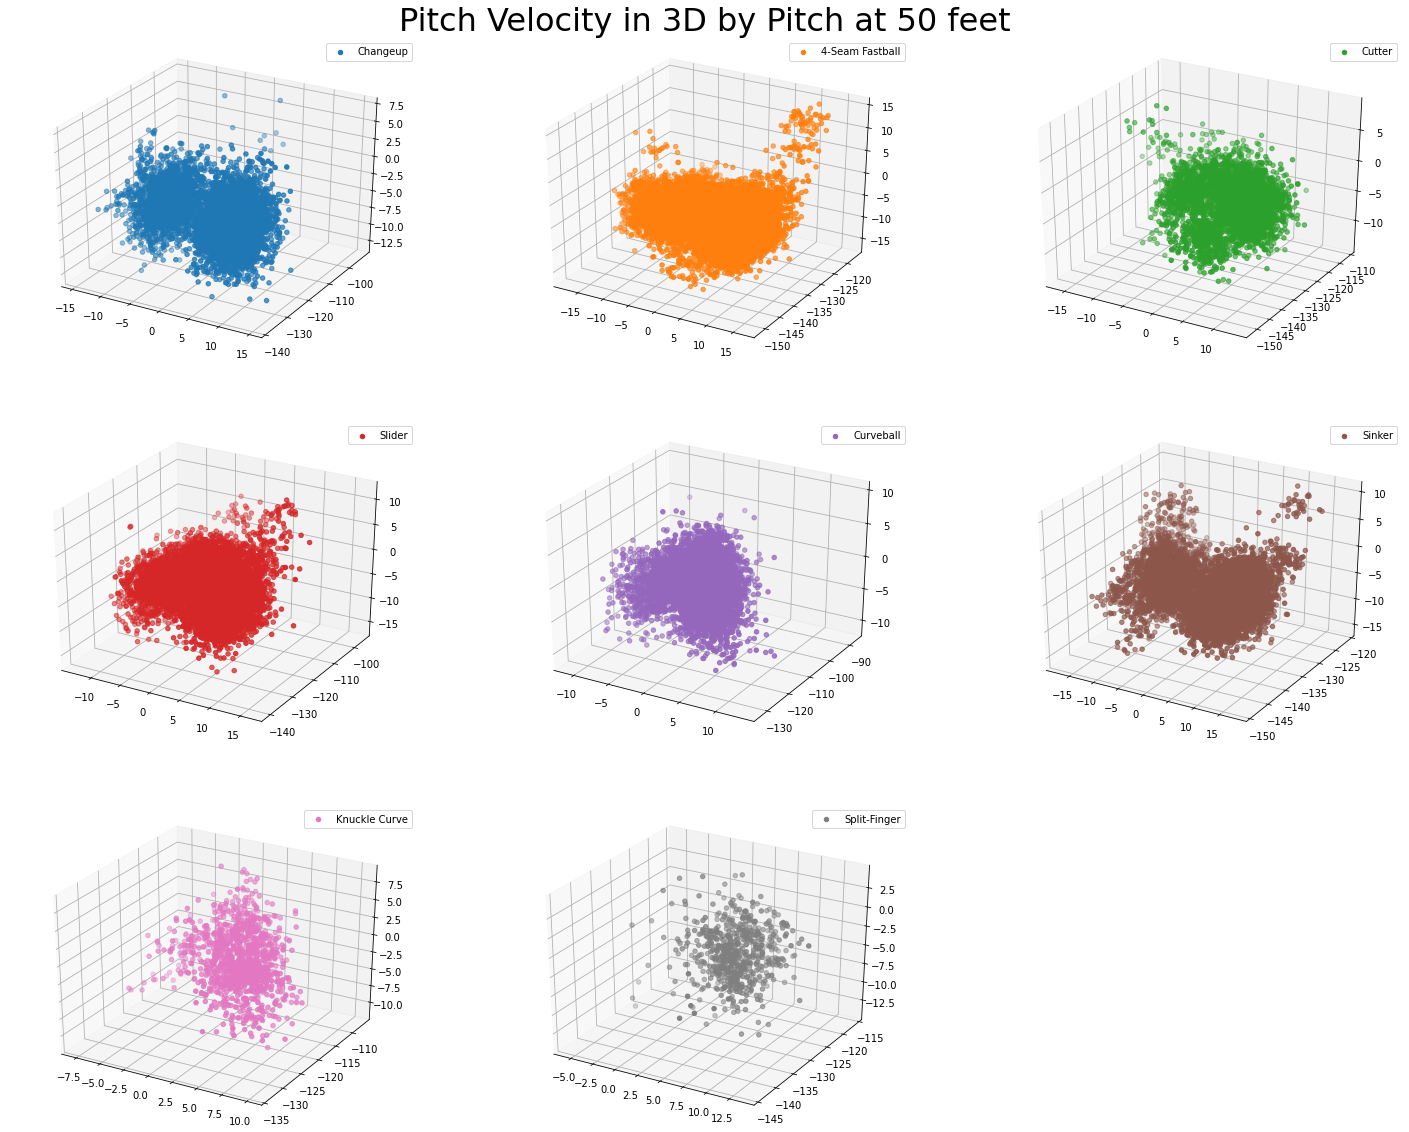

In [36]:
# 3D Scatterplot of Pitch Velocity at x=y=z=50 feet
fig_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Velocity in 3D by Pitch at 50 feet", fontsize = 32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For velocity in R^3 at 50 feet, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add 3D subplot to visualize 3D data
  ax_3D = fig_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = df.vx0[df.pitch_name==val]
  y = df.vy0[df.pitch_name==val]
  z = df.vz0[df.pitch_name==val]

  ax_3D.scatter(x,y,z,label=val, color = c)
  ax_3D.legend()

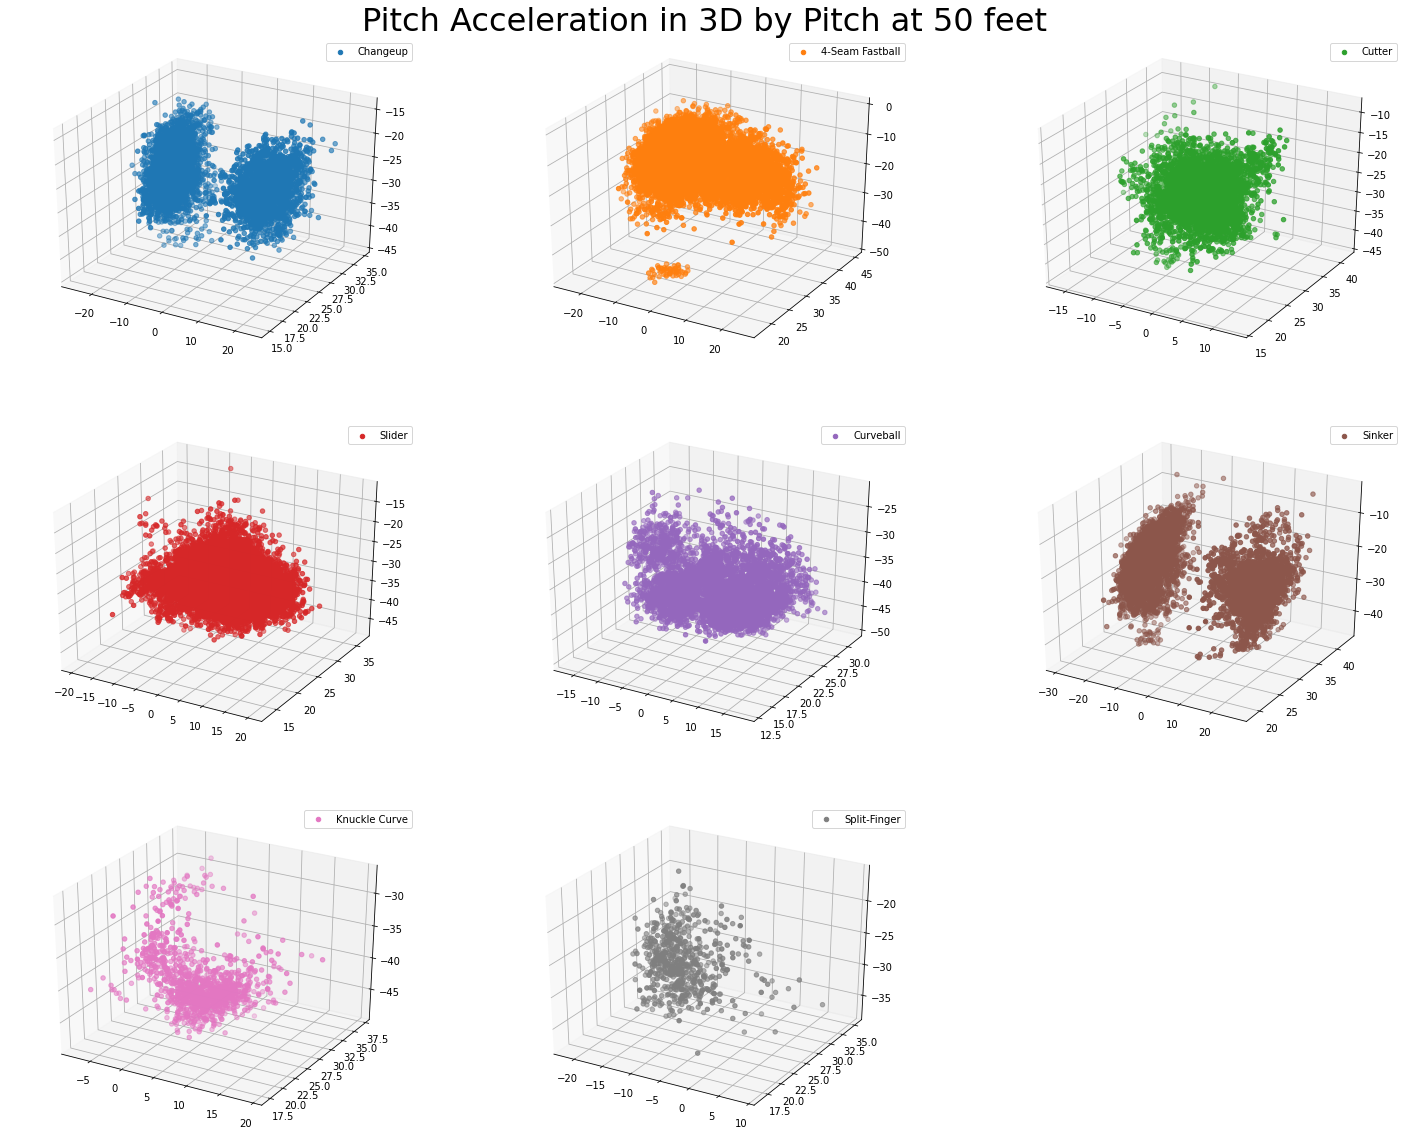

In [37]:
# 3D Scatterplot of Pitch acceleration in x,y,z dimensions at 50 feet
fig2_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Acceleration in 3D by Pitch at 50 feet", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add a 3D subplot to visualize 3D data
  ax2_3D = fig2_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = df.ax[df.pitch_name==val]
  y = df.ay[df.pitch_name==val]
  z = df.az[df.pitch_name==val]

  ax2_3D.scatter(x,y,z,label=val, color = c)
  ax2_3D.legend()

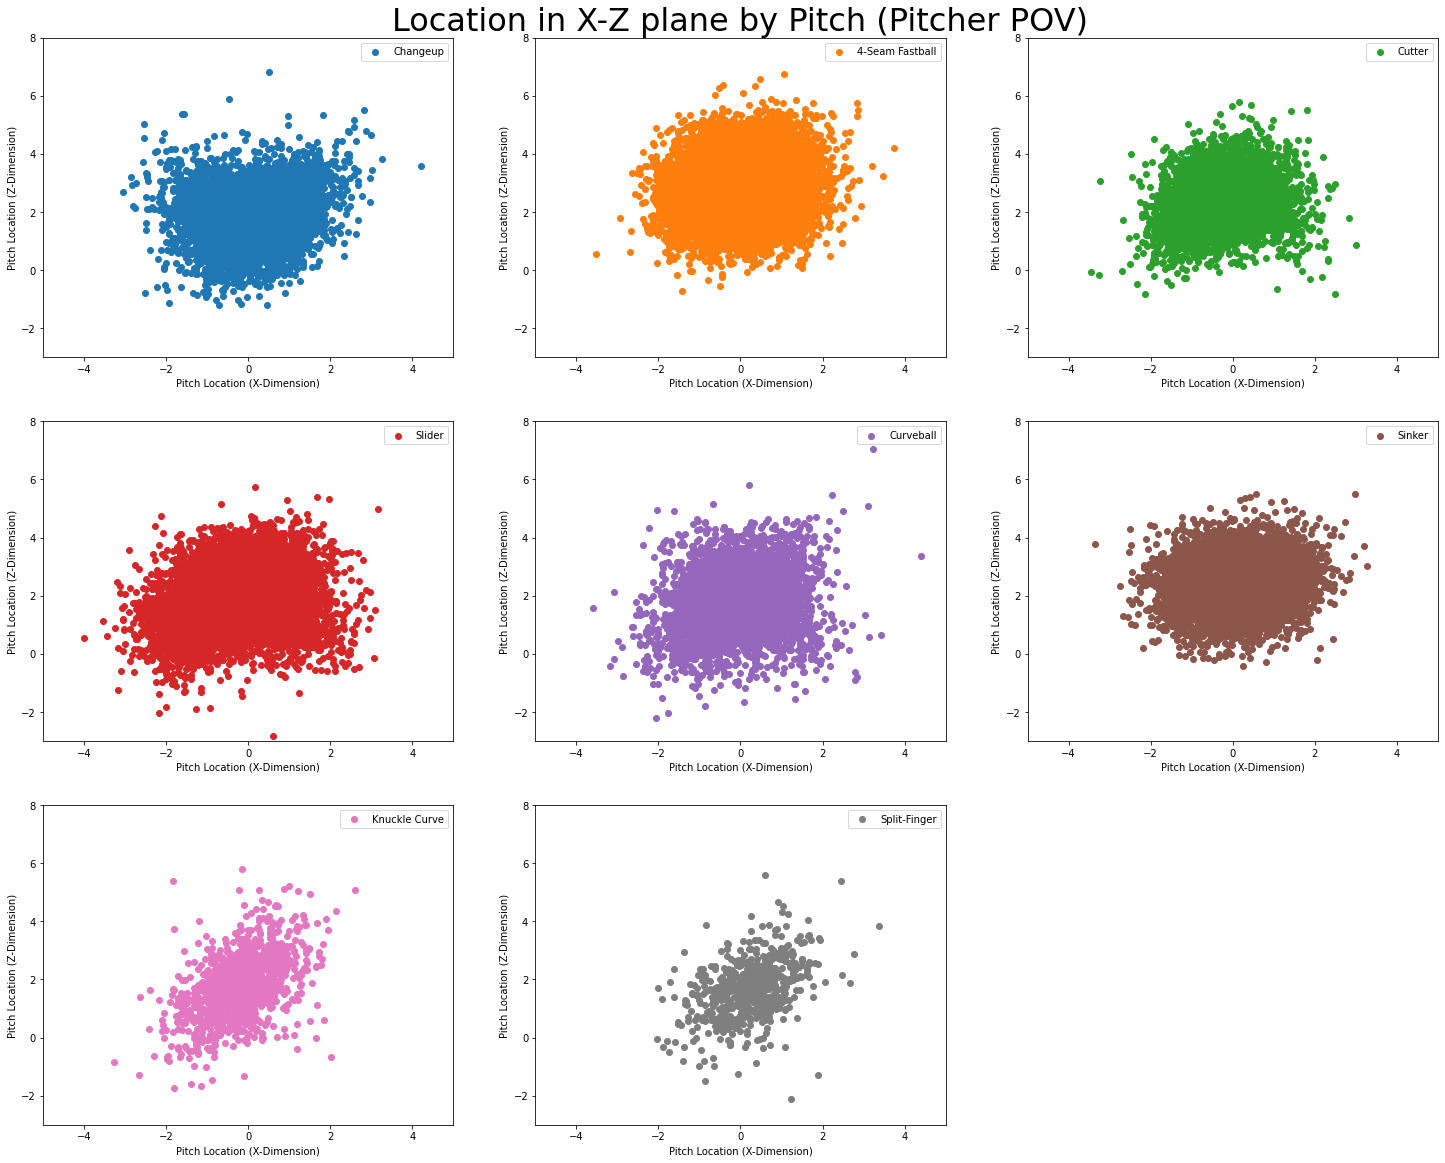

In [38]:
# Plate location plots
fig4 = plt.figure(figsize = (25,20))
plt.title("Location in X-Z plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax4 = fig4.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the pitch's location in the x-axis to get a pitcher's perspective
  x = df.plate_x[df.pitch_name==val] * -1
  y = df.plate_z[df.pitch_name==val]
  
  ax4.scatter(x=x, y=y,label=val, color = c)
  
  ax4.set_xlim(-5, 5)
  ax4.set_ylim(-3, 8)
  ax4.set_xlabel("Pitch Location (X-Dimension)")
  ax4.set_ylabel("Pitch Location (Z-Dimension)")
  ax4.legend()

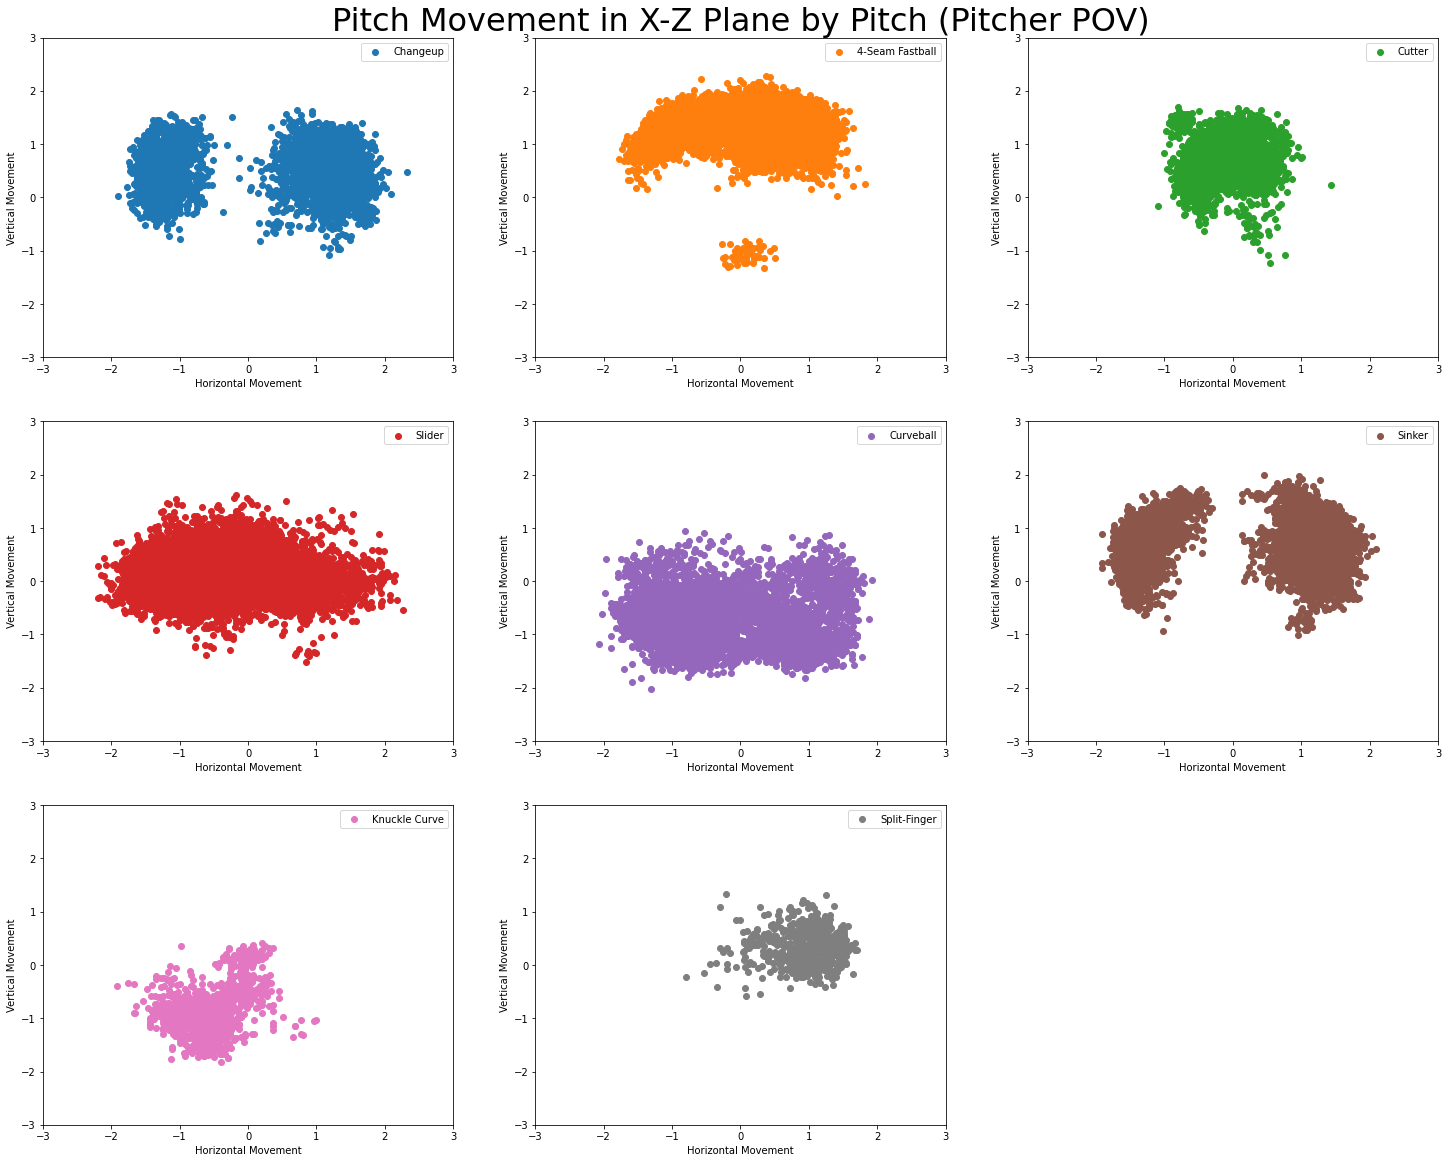

In [39]:
# Pitch movement scatterplots
fig5 = plt.figure(figsize = (25,20))
plt.title("Pitch Movement in X-Z Plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax5 = fig5.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the movement in the x-axis to get a pitcher's perspective
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val]
  ax5.scatter(x = x,y = y,label=val, color = c)
  
  ax5.set_xlim(-3, 3)
  ax5.set_ylim(-3, 3)
  ax5.set_xlabel("Horizontal Movement")
  ax5.set_ylabel("Vertical Movement")
  ax5.legend()

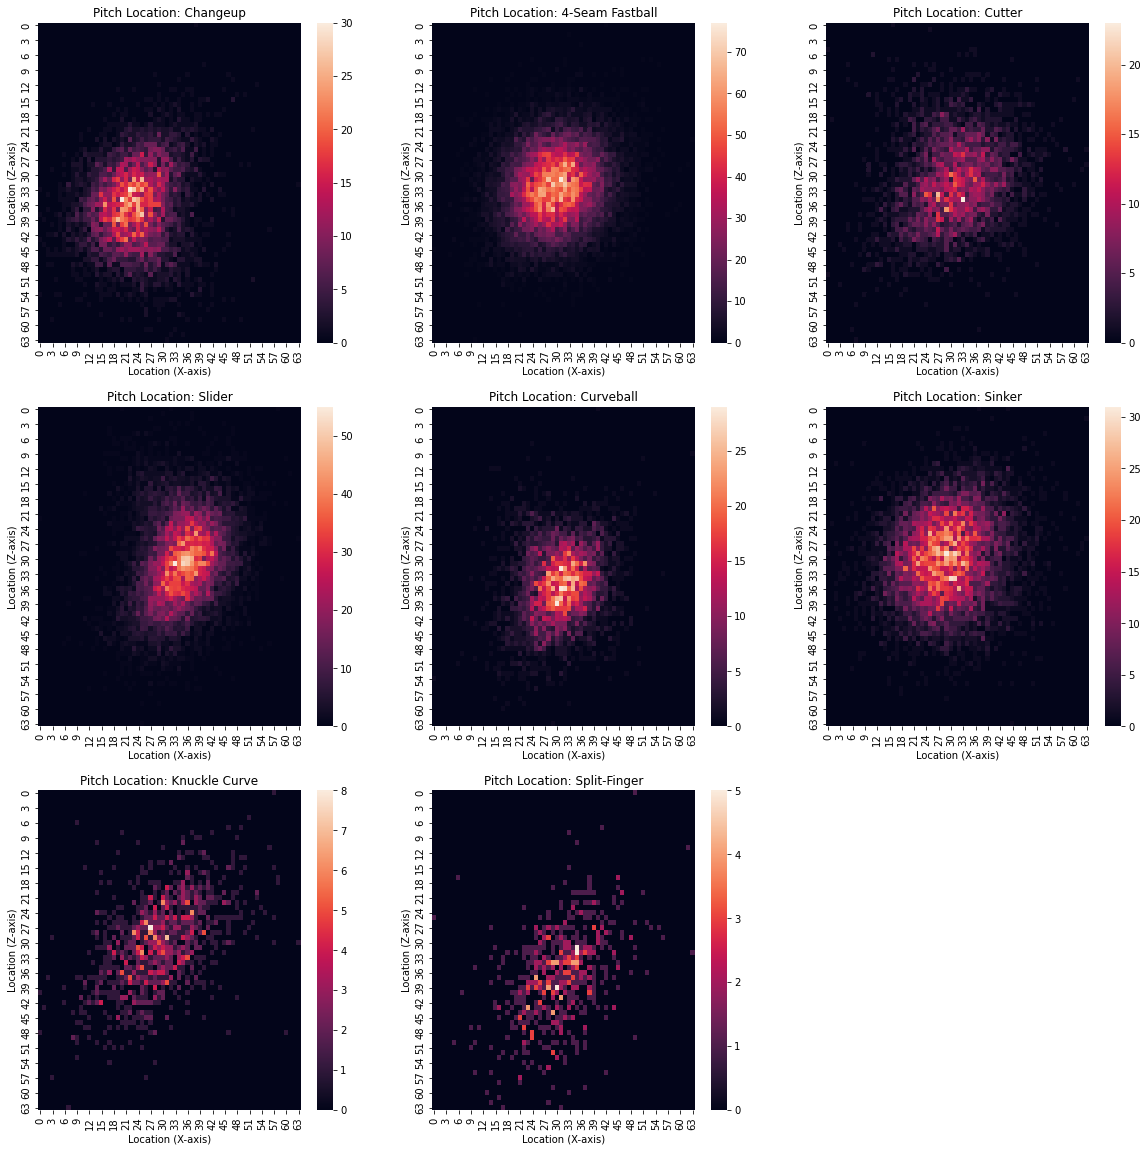

In [40]:
fig6 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax6 = fig6.add_subplot(3, 3, i+1)

  # Generate location data, convert into 2D array as a heatmap
  x = df.plate_x[df.pitch_name==val]
  y = df.plate_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot as heatmap
  sns.heatmap(heatmap)
  ax6.set(title = f"Pitch Location: {val}",
          xlabel = 'Location (X-axis)',
          ylabel = 'Location (Z-axis)')

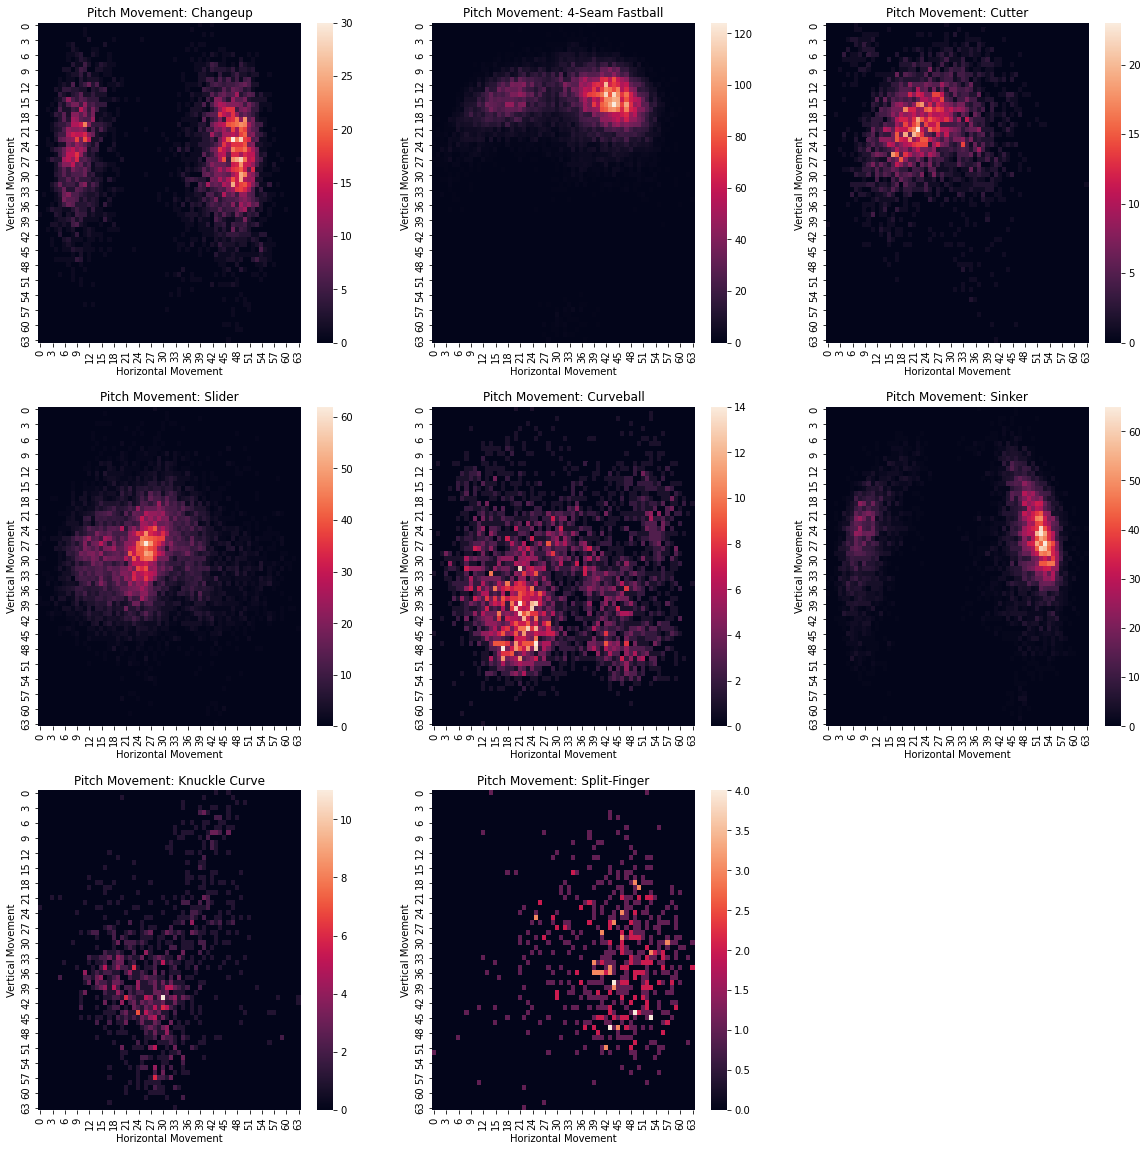

In [41]:
fig7 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax7 = fig7.add_subplot(3, 3, i+1)

  # Generate 3D data, convert to NumPy 2D Array
  # Flipped to match 2D Scatterplot for Movement
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val] * -1

  heatmap, xedges, yedges = np.histogram2d(y, x, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot
  sns.heatmap(heatmap)
  ax7.set(title = f"Pitch Movement: {val}",
          xlabel = 'Horizontal Movement',
          ylabel = 'Vertical Movement')



## Preprocessing

### Encoding Categorical Columns

In [42]:
X = df.drop(['pitcher',	'player_name', 'pitch_name'], axis=1)
y = df['pitch_name']

In [43]:
label_encoder = LabelEncoder()    

X['p_throws'] = label_encoder.fit_transform(X['p_throws'])
X

,p_throws,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,1,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,1,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,1,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55895,1,2326.0,94.5,95.6,208.0,4.263729,-137.495991,-7.372076,-15.902961,28.472445,-13.307007,-1.18,1.37,-0.74,2.03
55896,1,2487.0,88.9,89.2,189.0,4.120077,-129.293132,-5.742961,2.339776,26.856683,-17.589725,0.28,1.21,0.45,2.27
55897,1,2366.0,93.9,94.5,211.0,7.108558,-136.329495,-9.194264,-8.404847,29.701533,-9.224029,-0.55,1.69,0.98,1.69
55898,1,2088.0,86.0,87.5,189.0,5.011237,-125.264056,-4.112517,2.684455,21.237452,-23.822720,0.33,0.73,1.01,2.88


In [44]:
X.dtypes

p_throws               int64
release_spin_rate    float64
release_speed        float64
effective_speed      float64
spin_axis            float64
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
dtype: object

In [45]:
y

0               Changeup
1        4-Seam Fastball
2               Changeup
3        4-Seam Fastball
4                 Cutter
              ...       
55895             Sinker
55896             Cutter
55897    4-Seam Fastball
55898             Cutter
55899           Changeup
Name: pitch_name, Length: 55900, dtype: object

In [46]:
label_encoder2 = LabelEncoder()

y = label_encoder2.fit_transform(y)
y

array([1, 0, 1, ..., 0, 3, 1])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=0,
                                                    stratify = y) 

In [48]:
# Stratified sampling
def to_freq_dict(counter):
  ret_di = {}

  counter_total = sum(i[1] for i in counter)
  
  for i in counter:
    ret_di[i[0]] = round((i[1] / counter_total) * 100 , 1)

  return ret_di

pitch_freq = to_freq_dict(sorted(Counter(y).items(), key=itemgetter(0)))
y_train_freq = to_freq_dict(sorted(Counter(y_train).items(), key=itemgetter(0)))
y_test_freq = to_freq_dict(sorted(Counter(y_test).items(), key=itemgetter(0)))

print(pitch_freq)
print(y_train_freq)
print(y_test_freq)

{0: 32.2, 1: 11.1, 2: 8.9, 3: 7.4, 4: 2.0, 5: 16.3, 6: 20.8, 7: 1.1}
{0: 32.2, 1: 11.1, 2: 8.9, 3: 7.4, 4: 2.0, 5: 16.3, 6: 20.8, 7: 1.1}
{0: 32.2, 1: 11.1, 2: 8.9, 3: 7.4, 4: 2.0, 5: 16.3, 6: 20.8, 7: 1.1}


In [49]:
pitch_df = pd.DataFrame()
pitch_df['label'] = df['pitch_name']
pitch_df['encoded'] = y.tolist()
pitch_encoded = round( pitch_df.value_counts(sort=False, ascending=False) / len(df) * 100, 1)#/

pitch_encoded

label            encoded
4-Seam Fastball  0          32.2
Changeup         1          11.1
Curveball        2           8.9
Cutter           3           7.4
Knuckle Curve    4           2.0
Sinker           5          16.3
Slider           6          20.8
Split-Finger     7           1.1
dtype: float64

### Standardization

In [50]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

## Model Construction



https://www.analyticssteps.com/blogs/how-does-k-nearest-neighbor-works-machine-learning-classification-problem


https://www.analyticssteps.com/blogs/what-naive-bayes-algorithm-machine-learning

https://www.analyticssteps.com/blogs/how-use-random-forest-classifier-machine-learning



https://www.javatpoint.com/data-preprocessing-machine-learning


## K-Nearest Neighbors

In [72]:
# Default neighbors = 5
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier()

In [73]:
y_pred = KNN.predict(X_test)

In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[3458,    6,    0,   30,    0,  109,    1,    0],
       [   8, 1166,    0,    0,    0,   50,    1,   19],
       [   0,    0,  801,    1,   49,    0,  148,    0],
       [  51,    2,    4,  607,    0,    0,  168,    0],
       [   0,    2,   73,    1,  130,    0,   20,    1],
       [ 203,   40,    0,    5,    0, 1574,    1,    0],
       [  17,    7,  104,  131,    5,    1, 2063,    0],
       [   0,   65,    0,    0,    0,    3,    0,   55]])

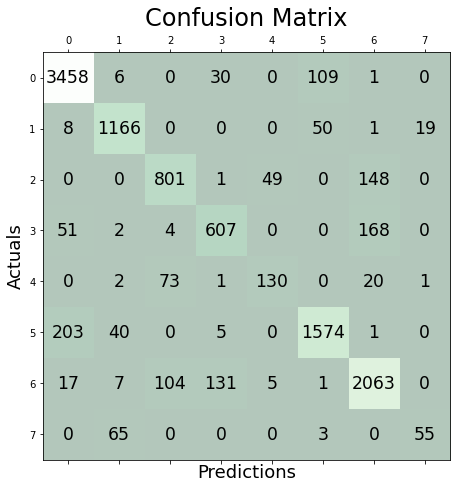

In [106]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Greens_r, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

In [76]:
rows = conf_matrix.sum(axis = 1, keepdims = True)
normalized_matrix = conf_matrix / rows

np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = np.round_(normalized_matrix, 4)
normalized_matrix

array([[0.000e+00, 1.700e-03, 0.000e+00, 8.300e-03, 0.000e+00, 3.020e-02,
        3.000e-04, 0.000e+00],
       [6.400e-03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.020e-02,
        8.000e-04, 1.530e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.000e-03, 4.900e-02, 0.000e+00,
        1.481e-01, 0.000e+00],
       [6.130e-02, 2.400e-03, 4.800e-03, 0.000e+00, 0.000e+00, 0.000e+00,
        2.019e-01, 0.000e+00],
       [0.000e+00, 8.800e-03, 3.216e-01, 4.400e-03, 0.000e+00, 0.000e+00,
        8.810e-02, 4.400e-03],
       [1.114e-01, 2.190e-02, 0.000e+00, 2.700e-03, 0.000e+00, 0.000e+00,
        5.000e-04, 0.000e+00],
       [7.300e-03, 3.000e-03, 4.470e-02, 5.630e-02, 2.100e-03, 4.000e-04,
        0.000e+00, 0.000e+00],
       [0.000e+00, 5.285e-01, 0.000e+00, 0.000e+00, 0.000e+00, 2.440e-02,
        0.000e+00, 0.000e+00]])

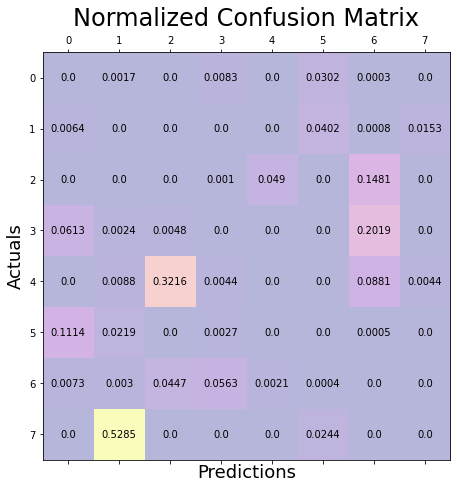

In [77]:
fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
ax2.matshow(normalized_matrix, cmap=plt.cm.plasma, alpha=0.3)

for i in range(normalized_matrix.shape[0]):
  for j in range(normalized_matrix.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix', fontsize=24)
plt.show()

In [78]:
# Recall what pitches were encoded to what number
pitch_encoded

label            encoded
4-Seam Fastball  0          32.2
Changeup         1          11.1
Curveball        2           8.9
Cutter           3           7.4
Knuckle Curve    4           2.0
Sinker           5          16.3
Slider           6          20.8
Split-Finger     7           1.1
dtype: float64

Findings:
* Some sinkers are misclassified as 4-seams
* Many predicted curveballs are actually knuckle-curves
*   The most alarming error is in splitters that are predicted as changeups. The inverse is not true, meaning that the model is not good at telling splitters from changeups given an instance of a splitter, but is good at predicting instances of changeups correctly and telling them from splitters.
*   Curveballs (both kinds) and cutters are misclassified as sliders



In [79]:
print("Testing set accuracy: ", KNN.score(X_test, y_test))
print("Training set accuracy: ", KNN.score(X_train, y_train))

Testing set accuracy:  0.8813953488372093
Training set accuracy:  0.9184704830053667


In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3604
           1       0.91      0.94      0.92      1244
           2       0.82      0.80      0.81       999
           3       0.78      0.73      0.76       832
           4       0.71      0.57      0.63       227
           5       0.91      0.86      0.88      1823
           6       0.86      0.89      0.87      2328
           7       0.73      0.45      0.56       123

    accuracy                           0.88     11180
   macro avg       0.83      0.77      0.80     11180
weighted avg       0.88      0.88      0.88     11180



##Naive Bayes

In [85]:
NB = GaussianNB()

NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

In [96]:
y_pred = NB.predict(X_test)
conf_matrix_nb = confusion_matrix(y_pred, y_test)
conf_matrix_nb

array([[3252,    0,    0,  106,    0,  346,    9,    0],
       [  14,  627,   15,   31,    5,   49,  123,   15],
       [  10,   22,  571,    9,   43,    3,  205,    0],
       [  97,    0,    1,  526,    0,    2,  334,    0],
       [   1,    0,  289,    3,  162,    0,   92,    0],
       [ 227,   73,    0,   27,    1, 1359,   13,    5],
       [   2,   58,  123,  130,   16,   29, 1549,    0],
       [   1,  464,    0,    0,    0,   35,    3,  103]])

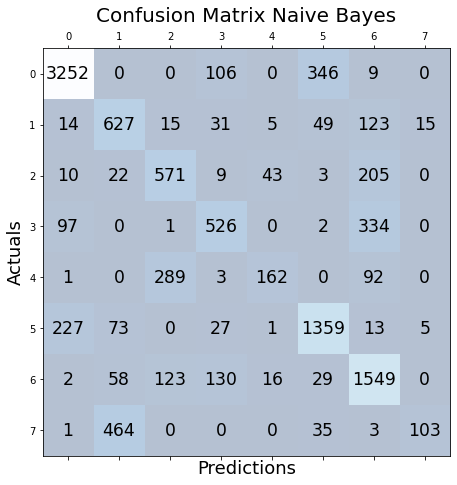

In [105]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix_nb, cmap=plt.cm.Blues_r, alpha=0.3)

for i in range(conf_matrix_nb.shape[0]):
    for j in range(conf_matrix_nb.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_nb[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Naive Bayes', fontsize=20)
plt.show()

In [98]:
rows_nb = conf_matrix_nb.sum(axis = 1, keepdims = True)
normalized_matrix_nb = conf_matrix_nb / rows_nb

np.fill_diagonal(normalized_matrix_nb, 0)
normalized_matrix_nb = np.round_(normalized_matrix_nb, 4)
normalized_matrix_nb

array([[0.000e+00, 0.000e+00, 0.000e+00, 2.850e-02, 0.000e+00, 9.320e-02,
        2.400e-03, 0.000e+00],
       [1.590e-02, 0.000e+00, 1.710e-02, 3.530e-02, 5.700e-03, 5.570e-02,
        1.399e-01, 1.710e-02],
       [1.160e-02, 2.550e-02, 0.000e+00, 1.040e-02, 4.980e-02, 3.500e-03,
        2.375e-01, 0.000e+00],
       [1.010e-01, 0.000e+00, 1.000e-03, 0.000e+00, 0.000e+00, 2.100e-03,
        3.479e-01, 0.000e+00],
       [1.800e-03, 0.000e+00, 5.283e-01, 5.500e-03, 0.000e+00, 0.000e+00,
        1.682e-01, 0.000e+00],
       [1.331e-01, 4.280e-02, 0.000e+00, 1.580e-02, 6.000e-04, 0.000e+00,
        7.600e-03, 2.900e-03],
       [1.000e-03, 3.040e-02, 6.450e-02, 6.820e-02, 8.400e-03, 1.520e-02,
        0.000e+00, 0.000e+00],
       [1.700e-03, 7.657e-01, 0.000e+00, 0.000e+00, 0.000e+00, 5.780e-02,
        5.000e-03, 0.000e+00]])

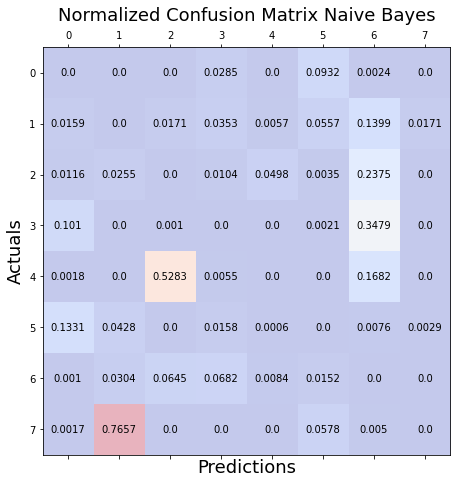

In [102]:
fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
ax2.matshow(normalized_matrix_nb, cmap=plt.cm.coolwarm, alpha=0.3)

for i in range(normalized_matrix_nb.shape[0]):
  for j in range(normalized_matrix_nb.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix_nb[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix Naive Bayes', fontsize=18)
plt.show()

Overall, worse performance than the KNN classifier, with the errors the KNN increasing in magnitude.

In [100]:
print("Naive Bayes Testing set accuracy: ", NB.score(X_test, y_test))
print("Naive Bayes Training set accuracy: ", NB.score(X_train, y_train))

Naive Bayes Testing set accuracy:  0.7288908765652952
Naive Bayes Training set accuracy:  0.7315295169946333


In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3604
           1       0.71      0.50      0.59      1244
           2       0.66      0.57      0.61       999
           3       0.55      0.63      0.59       832
           4       0.30      0.71      0.42       227
           5       0.80      0.75      0.77      1823
           6       0.81      0.67      0.73      2328
           7       0.17      0.84      0.28       123

    accuracy                           0.73     11180
   macro avg       0.61      0.70      0.61     11180
weighted avg       0.77      0.73      0.74     11180



## Random Forest Classifier

In [113]:
# Default Estimaotrs = 100, criterion = 'gini'
rfc = RandomForestClassifier()

In [114]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [115]:
conf_matrix_rfc = confusion_matrix(y_pred, y_test)
conf_matrix_rfc

array([[3461,    2,    0,   59,    0,  164,   11,    0],
       [   4, 1188,    0,    2,    1,   35,    8,   65],
       [   0,    1,  796,    6,   79,    0,   82,    0],
       [  40,    0,    0,  583,    0,    1,  111,    0],
       [   0,    0,   21,    0,  125,    0,    2,    0],
       [  97,   44,    0,    1,    0, 1620,    0,    4],
       [   2,    2,  182,  181,   21,    2, 2114,    0],
       [   0,    7,    0,    0,    1,    1,    0,   54]])

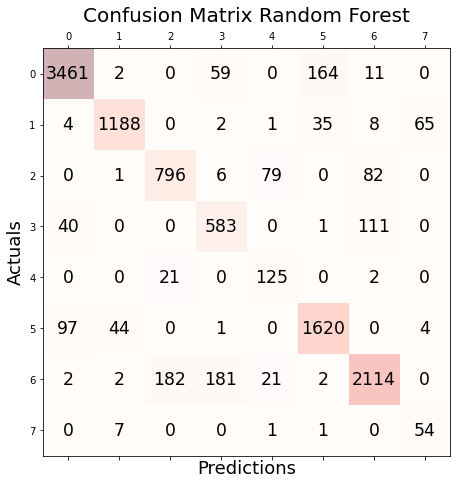

In [117]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix_rfc, cmap=plt.cm.Reds, alpha=0.3)

for i in range(conf_matrix_rfc.shape[0]):
    for j in range(conf_matrix_rfc.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_rfc[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Random Forest', fontsize=20)
plt.show()

In [119]:
rows_rfc = conf_matrix_rfc.sum(axis = 1, keepdims = True)
normalized_matrix_rfc = conf_matrix_rfc / rows_rfc

np.fill_diagonal(normalized_matrix_rfc, 0)
normalized_matrix_rfc = np.round_(normalized_matrix_rfc, 4)
normalized_matrix_rfc

array([[0.    , 0.0005, 0.    , 0.016 , 0.    , 0.0444, 0.003 , 0.    ],
       [0.0031, 0.    , 0.    , 0.0015, 0.0008, 0.0269, 0.0061, 0.0499],
       [0.    , 0.001 , 0.    , 0.0062, 0.082 , 0.    , 0.0851, 0.    ],
       [0.0544, 0.    , 0.    , 0.    , 0.    , 0.0014, 0.151 , 0.    ],
       [0.    , 0.    , 0.1419, 0.    , 0.    , 0.    , 0.0135, 0.    ],
       [0.0549, 0.0249, 0.    , 0.0006, 0.    , 0.    , 0.    , 0.0023],
       [0.0008, 0.0008, 0.0727, 0.0723, 0.0084, 0.0008, 0.    , 0.    ],
       [0.    , 0.1111, 0.    , 0.    , 0.0159, 0.0159, 0.    , 0.    ]])

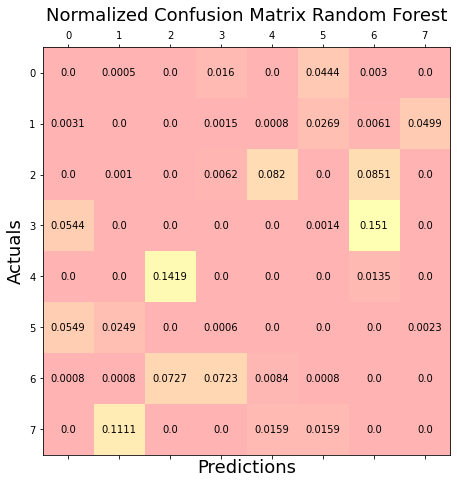

In [120]:
fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
ax2.matshow(normalized_matrix_rfc, cmap=plt.cm.autumn, alpha=0.3)

for i in range(normalized_matrix_rfc.shape[0]):
  for j in range(normalized_matrix_rfc.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix_rfc[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix Random Forest', fontsize=18)
plt.show()

In [121]:
print("Random Forest Classifier Testing set accuracy: ", rfc.score(X_test, y_test))
print("Random Forest Classifier Training set accuracy: ", rfc.score(X_train, y_train))

Random Forest Classifier Testing set accuracy:  0.8891771019677996
Random Forest Classifier Training set accuracy:  1.0


In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3604
           1       0.91      0.95      0.93      1244
           2       0.83      0.80      0.81       999
           3       0.79      0.70      0.74       832
           4       0.84      0.55      0.67       227
           5       0.92      0.89      0.90      1823
           6       0.84      0.91      0.88      2328
           7       0.86      0.44      0.58       123

    accuracy                           0.89     11180
   macro avg       0.87      0.77      0.81     11180
weighted avg       0.89      0.89      0.89     11180



### Random Forest Classifier ROC

In [183]:
y_proba = rfc.predict_proba(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_OvR_test = label_binarizer.transform(y_test)
y_OvR_test.shape  # (n_samples, n_classes)

(11180, 8)

In [184]:
four_seam_class = 0
class_id = np.flatnonzero(label_binarizer.classes_ == four_seam_class)[0]
class_id

0

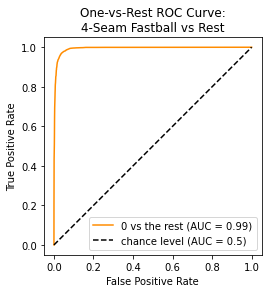

In [185]:
RocCurveDisplay.from_predictions(
    y_OvR_test[:, class_id],
    y_proba[:, class_id],
    name=f"{four_seam_class} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curve:\n4-Seam Fastball vs Rest")
plt.legend()
plt.show()

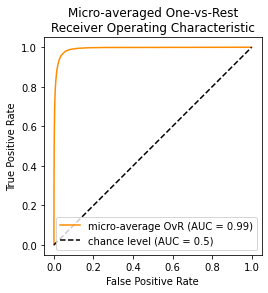

In [186]:
RocCurveDisplay.from_predictions(
    y_OvR_test.ravel(),
    y_proba.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [187]:
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_OvR_test.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99


In [191]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_OvR_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


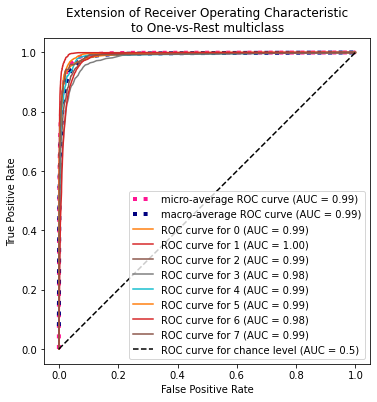

In [192]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = plt.rcParams["axes.prop_cycle"]()


for class_id, color in zip(range(n_classes), colors):
    c = next(colors)["color"]
    
    RocCurveDisplay.from_predictions(
        y_OvR_test[:, class_id],
        y_proba[:, class_id],
        name=f"ROC curve for {class_id}",
        color=c,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()